# Field Apps Deployment using Python

<img src="https://www.esri.com/content/dam/esrisites/en-us/common/icons/product-logos/arcgis-field-maps-220.png" width="100">

#### Getting your ArcGIS Field Maps workers set up for an event can be a time-consuming and mistake-ridden process. In this demo, we're going to show how you can utilize the ArcGIS API for Python to improve the speed and accuracy of setup for three different forms of data collection:

Note: this requires the ArcGIS API for Python 1.8.4 (released Jan 2021). Much of this notebook also requires having admin privileges in your organization. This notebook was originally created as part of DevSummit 2021.


1. Location Tracking (Enable LTS, Create Track View, Assign Licenses)
2. Forms data collection (Create Map, Create Form, Copy Form Between Maps, QR code generation)
3. Workforce coordination (Create a Project, Create Assignment Types, Add Workers, Add Assignments)



## Location Tracking

Location tracking is a feature that enables organizations to capture the tracks of field staff, monitor where they are, and analyze where they have been. Patterns derived from location tracks give decision-makers information to support critical field activities.

Tracks can be collected either via ArcGIS Field Maps or ArcGIS Tracker if your organization has purchased ArcGIS Tracker licenses and field workers have been assigned those licenses. Since setting up licenses and track views for a group of workers may be a time-consuming task, let's use the ArcGIS API for Python `arcgis.apps.tracker` [module](https://developers.arcgis.com/python/api-reference/arcgis.apps.tracker.html) to speed up this workflow!

In order to start location tracking, let's make sure it's enabled at an organizational level for my org.

In [1]:
# Enable Location Tracking

import arcgis
gis = arcgis.gis.GIS("<org_url>", "<insert_user_here>")
status = gis.admin.location_tracking.status
print("Location Tracking Status: " + status)
print("Enabling")
if status == "disabled":
    gis.admin.location_tracking.enable()
print("New Location Tracking Status: " + gis.admin.location_tracking.status)

Enter password: ········
Location Tracking Status: disabled
Enabling
New Location Tracking Status: enabled


#### Assign ArcGIS Tracker licenses

In order to activate tracking in ArcGIS Tracker or Field Maps, ArcGIS Tracker licenses must be assigned to workers. This can be a time consuming process, but it's quite simple in Python.

In [2]:
# Assign Tracker licenses to group users

group = gis.groups.search('workers')[0]
print(group)
members = group.get_members()
print(members)
print("\n")
tracker_license = gis.admin.license.get('arcgis tracker')
for user in members['users']:
    tracker_license.assign(user, ["tracker"])
print("Assigned!")

<Group title:"workers" owner:tracker2admin>
{'owner': 'tracker2admin', 'admins': ['tracker2admin'], 'users': ['apulver_tracker2', 'automation', 'fullname1', 'fullname2', 'fullname3', 'jmcmanus_tracker2', 'jshaner_tracker2', 'nchowdhury_tracker2', 'tbeauchamp_tracker2']}


Assigned!


#### Now, let's pull all of our users into a track view - that will make visualizing tracks through ArcGIS Track Viewer much simpler

To make a track view, we can also utilize the `tracker` [module](https://developers.arcgis.com/python/api-reference/arcgis.apps.tracker.html) here.

In [3]:
# Add Tracker users from same group to new track view as mobile users

track_view = gis.admin.location_tracking.create_track_view('workers_view')
track_view.mobile_users.add(members['users'])
print("Number of users in track view: " + str(len(track_view.mobile_users.list())))


Number of users in track view: 9


#### Finally, let's generate an easy QR code using the Python QRCode library that my field workers can scan in order to login and begin tracking

Scanning this and logging into Field Maps will turn on tracking for a 10 hour duration. For more on our app linking parameters, our documentation can be found [here](https://doc.arcgis.com/en/field-maps/android/help/deploy-your-map.htm). For more location tracking usecases, please visit our Tracker Github [repository](https://github.com/Esri/tracker-scripts)

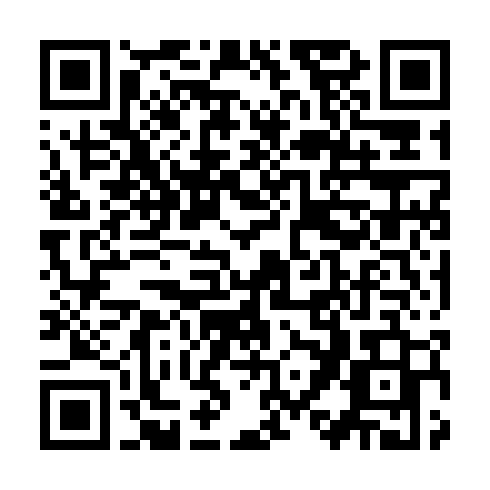

In [4]:
import qrcode
begin_tracking_url = "https://fieldmaps.arcgis.app/?referenceContext=track&trackingOn=true&trackingDuration=10"
img = qrcode.make(begin_tracking_url)
img

## Forms Data Collection

Smart forms are the new way to edit non-spatial information about GIS features in ArcGIS Field Maps. Forms are built upon existing, published web feature layers and the form you create is stored in your map. Smart forms allow much more customization of the data collection experience compared to older workflows.

While most users will create their smart forms using the ArcGIS Field Maps web app, there may be situations where a GIS administrator needs to batch create a variety of forms in an efficient manner. In this instance, the new `arcgis.mapping.forms` (being released at ArcGIS API for Python version 1.8.4) is a great tool for you.

In this particular example, I'll create a smart form for a publicly available emergency shelters layer. Notice how I create my own form for a layer I do not own, since the form information resides in my webmap rather than their layer.


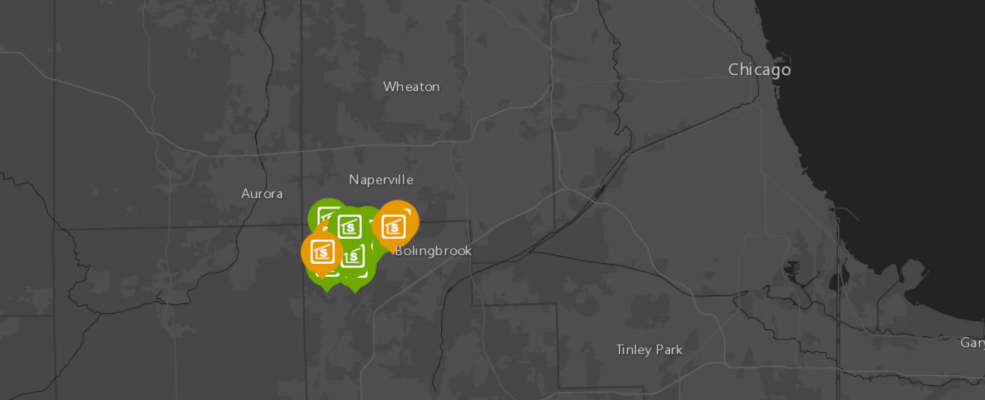

In [5]:
# Create Map with new feature layer

wm = gis.map()
wm.add_layer(arcgis.features.FeatureLayer(url="https://sampleserver6.arcgisonline.com/arcgis/rest/services/NapervilleShelters/FeatureServer/0"))
wm.basemap = 'dark-gray'
wm.center = 41.75, -88
wm.zoom = 10
wm

In [6]:
# save widget into new wm, create form
wm = wm.save(item_properties={"title": "Shelters Form Map", "snippet": "Map for shelters", "tags": ["shelters"]})
wm = arcgis.mapping.WebMap(wm)
form = wm.forms.get(title='Shelters')
form.title = "Shelters Layer"
form.add_field(field_name="facilityid", label="Facility ID")
form.add_field(field_name="jurisdict", label="New Jursdiction")
print(form)

{
  "expressionInfos": [],
  "formElements": [
    {
      "label": "Facility ID",
      "type": "field",
      "fieldName": "facilityid"
    },
    {
      "label": "New Jursdiction",
      "type": "field",
      "fieldName": "jurisdict"
    }
  ],
  "title": "Shelters Layer"
}


### We can easily populate a form using the functions present in the forms module - this allows us to bypass the web application and perform all operations in Python

I can do the same sorts of actions present in the Field Maps web app - adding groups, changing form properties, and add the same types of conditional visibility expressions to ensure the form element "New Jurisdiction" only shows up if "Facility ID" is equal to a certain value

In [7]:
# Property changes, groups, conditional visibility

group = form.add_group(label="Contact Information")
group.add_field(field_name="pocname", label="Point of Contact Name")
group.add_field(field_name="pocemail", label="Point of Contact Email")
group.initial_state = "expanded"
group.visibility_expression = arcgis.mapping.forms.FormExpressionInfo(name="expr0", title="New Expression", expression="$feature.facilityid == '1'")
print(form)

# save form into backend
form.update()

{
  "expressionInfos": [
    {
      "name": "expr0",
      "title": "New Expression",
      "expression": "$feature.facilityid == '1'",
      "returnType": "boolean"
    }
  ],
  "formElements": [
    {
      "label": "Facility ID",
      "type": "field",
      "fieldName": "facilityid"
    },
    {
      "label": "New Jursdiction",
      "type": "field",
      "fieldName": "jurisdict"
    },
    {
      "label": "Contact Information",
      "type": "group",
      "visibilityExpression": "expr0",
      "formElements": [
        {
          "label": "Point of Contact Name",
          "type": "field",
          "fieldName": "pocname"
        },
        {
          "label": "Point of Contact Email",
          "type": "field",
          "fieldName": "pocemail"
        }
      ],
      "initialState": "expanded"
    }
  ],
  "title": "Shelters Layer"
}


### Batch operations with forms

We could use this Python module to perform batch operations with forms that may be slower in the web application. For example, let's say I now want to use this same form in a different map that uses the same operational layer. This is relatively easily when given the forms module!

For more on what you can accomplish with the forms module, please visit our [documentation](https://developers.arcgis.com/python/api-reference/arcgis.mapping.forms.html)

In [8]:
wm2 = arcgis.mapping.WebMap(gis.content.get('f68890942772404d9dfbb5e055eacb83'))
print(wm2.forms.get(title='Shelters'))

None


In [9]:
new_form = wm2.forms.get(title='Shelters')
new_form = form
print(new_form)
new_form.update()

{
  "expressionInfos": [
    {
      "name": "expr0",
      "title": "New Expression",
      "expression": "$feature.facilityid == '1'",
      "returnType": "boolean"
    }
  ],
  "formElements": [
    {
      "label": "Facility ID",
      "type": "field",
      "fieldName": "facilityid"
    },
    {
      "label": "New Jursdiction",
      "type": "field",
      "fieldName": "jurisdict"
    },
    {
      "label": "Contact Information",
      "type": "group",
      "visibilityExpression": "expr0",
      "formElements": [
        {
          "label": "Point of Contact Name",
          "type": "field",
          "fieldName": "pocname"
        },
        {
          "label": "Point of Contact Email",
          "type": "field",
          "fieldName": "pocemail"
        }
      ],
      "initialState": "expanded"
    }
  ],
  "title": "Shelters Layer"
}


## Workforce Coordination

ArcGIS Workforce is a mobile solution that uses the power of location-based decision making for better mobile workforce coordination and teamwork. It's composed of a web app used by project administrators and dispatchers in the office, and a mobile app used by mobile workers on their devices.

Users may want to utilize the ArcGIS API for Python `workforce` module to automate tasks. Automation is especially useful when managing Workforce projects that contain a large number of workers and assignments. Import workers from a CSV file, assign work, create a dashboard, delete assignments, reset worker status, and more with ArcGIS API for Python.

Note here that you can use the Python API to create your "classic" Workforce projects which work with the older version of the Workforce mobile application.

In [10]:
# create new project, create "classic" workforce project

new_proj = arcgis.apps.workforce.create_project("new_project", major_version=2)
old_proj = arcgis.apps.workforce.create_project("old_project", major_version=1)
print(new_proj)
print(old_proj)

new_project
old_project


#### Project Setup

Now that we've got our project, we're ready to get it setup for automation! Workforce projects require both assignment types to categorize your assignments and workers to send assignments. Using the group we already have from earlier in the demo, let's get our workers into the project and ready to work.

In [11]:
print("Adding assignment types and workers")
at = new_proj.assignment_types.add(name="Demolition")
for user in members['users']:
    new_proj.workers.add(user_id=user, name=user)
print("Assignment types and workers added")

Adding assignment types and workers
Assignment types and workers added


In [12]:
# Add an assignment

new_proj.assignments.add(assignment_type=at, location="100 Commercial St", geometry={'x': -7820308, 'y': 5412450}, status=0,
                                        description="hello")

<Assignment 1>

### Resources

This is just a brief introduction into what is possible with task and data management using the ArcGIS API for Python. We have lots of examples available to learn how to write your own scripts and customize these notebooks as you see fit. Here's a non-comprehensive list of resources available:

- [ArcGIS API for Python homepage](https://developers.arcgis.com/python/)
- [API documentation](https://developers.arcgis.com/python/api-reference/)
- [Workforce Scripts](https://github.com/Esri/workforce-scripts)
- [Tracker Scripts](https://github.com/Esri/tracker-scripts)
- [Automating Workforce with Python Blog](https://www.esri.com/arcgis-blog/products/workforce/field-mobility/automate-workforce-with-arcgis-api-for-python/)
